In [1]:
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.datasets.samples_generator import make_circles
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.cm as cm
from scipy import linalg
import numpy as np
import pandas as pd
import random
import math


In [2]:
var = 0.5;
n_samples = 100
mu = 1
v = 1
weight_limit = 0

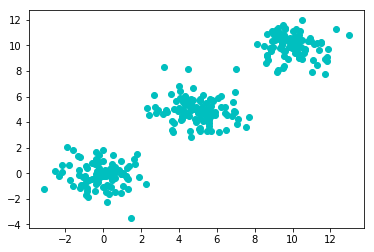

In [3]:


"""
noise = 0.1*np.random.normal(0,1,100)
X = np.ndarray(shape=(n_samples,2), dtype=float, order='F')
y = np.ndarray(shape=(n_samples), dtype=float, order='F')

x = np.arange(0,1,1/n_samples)
for t, i in zip(x, range(0,n_samples)):
    y[i] = math.sin(4*math.pi*t) + noise[i]
    X[i] = [math.cos(2*math.pi*t), math.sin(2*math.pi*t)]
"""
n_samples = 100
#beta [0 1]
x_1, y = make_blobs(n_samples=n_samples, n_features=2, centers = [[0., 0.]], cluster_std=1.0)
#beta [1 0]
x_2, y = make_blobs(n_samples=n_samples, n_features=2, centers=[[5., 5.]], cluster_std=1.0)
#beta [1 1]
x_3, y = make_blobs(n_samples=n_samples, n_features=2, centers=[[10., 10.]], cluster_std=1.0)
#X, y = make_circles(n_samples=15, shuffle=True, noise=None, random_state=None, factor=0.8)
X = np.block([[x_1], [x_2], [x_3]])

y_1 = np.zeros(n_samples)
y_2 = np.zeros(n_samples)
y_3 = np.zeros(n_samples)

X_data = np.array(X)
p = len(X[0,:])
n = len(X[:,0])

for i in range(0,n_samples): 
    y_1[i] = 1 + 0 * x_1[i,0]+ x_1[i,1]
    y_2[i] = 1 + 1* x_2[i,0]+0*x_2[i,1]
    y_3[i] = 1 + x_3[i,0]+ x_3[i,1]

y_data= np.concatenate((y_1, y_2, y_3))
#y = np.block([[y_1], [y_2], [y_3]])

fig = plt.figure()
#ax = plt.axes(projection='3d')
    
#plt.plot(X[:, 0], X[:, 1], y,'co')
plt.plot(X_data[:, 0], X_data[:, 1], 'co')
plt.show()
#y_matrix = np.matrix(y)
#ax = plt.axes(projection='3d')



In [36]:
#LLR
class LLR():
    
    def __init__(self):
        self.mode = ''

     
    def fit(self, X, y, mu, v, mode='compress', perm_size = 50):
        p = len(X[0,:])
        n = len(X[:,0])
        self.perm_size = perm_size
        self.Y = np.zeros(n)
        self.W = np.zeros((len(X[:, 0]), len(X[:, 0])))
        self.X = X
        
        # Compute the weight matrix of X
        for i in range(0, len(X[:, 0])):
            for j in range(0, len(X[:, 0])):
                if i != j:
                    self.W[i,j] = math.exp((-1)*np.linalg.norm(X[i]-X[j])**2/var**2);    
        
        D_compress = np.zeros((len(X[:, 0]), len(X[:, 0])))
        D_inv_compress = np.zeros((len(X[:, 0]), len(X[:, 0])))
        G = np.random.normal(0, 1, (perm_size, len(X[:, 0])))
        E = np.zeros((len(X[:, 0]), perm_size))

        # to store data of the reduced X
        W_small = np.zeros((perm_size, perm_size))
        A = np.zeros((perm_size, perm_size))
        D = np.zeros((perm_size, perm_size))
        D_inv = np.zeros((perm_size, perm_size))

        self.perm = random.sample(range(0, len(X[:, 0])), perm_size)
        q, r, self.perm = linalg.qr(np.matmul(G,self.W), pivoting=True)

        # pick the columns of W with biggest eigenvalues
        for i in range(0, perm_size): 
            E[:,i] = self.W[:, (self.perm[i])];
        E = np.mat(E)

        # Compute the degrees of the choosen columns 
        for i in range(0, len(X[:, 0])):
            D_compress[i,i] = np.sum(E[i,:]);
            if D_compress[i,i] == 0:
                raise ValueError("Some vertices in the graph are not connected.")
            D_inv_compress[i,i] = 1/D_compress[i,i];

        # Compute the normalized wieght matrix of the choosen columns
        self.W_asym = np.matmul(D_inv_compress, E)

        W_A = np.block([self.W_asym, np.zeros((n, perm_size*p))]);
        for i in range(1, p+1):
            W_A_temp = np.block([np.zeros((n,i*perm_size)), self.W_asym, np.zeros((n, p*perm_size-i*perm_size))]);    
            W_A = np.block([[W_A], [W_A_temp]])
            
        '''fig = plt.figure()
        plt.imshow(W_A)
        plt.show()'''
        
        # Compute the square weight matrix with only the choosen columns of X
        n = perm_size
        for i in range(0, perm_size):
            for j in range(0, perm_size):
                if i != j:
                    W_small[i,j] = math.exp((-1)*np.linalg.norm(X[self.perm[i]]-self.X[self.perm[j]])**2/var**2);  

        # Find the degree of the columns of the reduced X matrix  
        for i in range(0, perm_size):
            D[i,i] = np.sum(W_small[i,:]);
            if D[i,i] == 0:
                raise ValueError("Some vertices in the graph are not connected.")
            D_inv[i,i] = 1/D[i,i];

        # Compute the Laplacian matrix of reduced X matrix
        L = np.subtract(np.identity(perm_size), np.matmul(D_inv, W_small))

        # Keep only the choosed columns of X and their y values
        X_new = self.X[self.perm[0], :]
        y_new = y[self.perm[0]]
        for i in range(1, perm_size):
            X_new = np.block([[X_new], [self.X[self.perm[i], :]]])
            y_new = np.block([[y_new],[y[self.perm[i]]]])   

        # Constructing X_block matrix of smaller X
        self.X_block = np.identity(perm_size)
        for i in range(0, len(X[0, :])):
            self.X_block = np.block([self.X_block, np.diag(X_new[:,i])]);

        # Constructing M block matrix of smaller X
        M_alpha = np.block([mu*L, np.zeros((perm_size, perm_size*p))]);
        M_beta = np.block([np.zeros((perm_size,perm_size)), (v/p)*L, np.zeros((perm_size, perm_size*p-perm_size))]);

        for i in range(1, p):
            M_temp = np.block([np.zeros((perm_size,(i+1)*perm_size)), (v/p)*L, np.zeros((perm_size, perm_size*p+perm_size-(i+2)*perm_size))]);    
            M_beta = np.block([[M_beta], [M_temp]])

        M = np.block([[M_alpha], [M_beta]])
        M = np.mat(M);
        '''
        fig = plt.figure()
        plt.imshow(M)
        plt.show()
        '''

        #Compute the theta of smaller X 
        self.X_block = np.mat(self.X_block);
        to_invert = np.matmul(self.X_block.transpose(),self.X_block) + M
        u, s, vh = np.linalg.svd((to_invert), full_matrices=True)

        for i in range(0, len(s)):
            s[i] = 1/s[i]

        inverse = np.matmul(np.matmul(vh.transpose(),np.diag(s)),u.transpose())
        self.Theta = np.matmul(np.matmul(inverse,self.X_block.transpose()),y_new)

        #extrapolate theta to the whole dataset
        Theta = np.matmul(W_A, self.Theta); 
        self.weight = W_A

        # Compute the predicted y values
        n = len(X[:,:])
        for i in range(0, len(X[:,:])):   
            temp = 0
            for j in range (1, len(X[0,:])+1):
                temp = temp + Theta[i+j*n, 0]*X[i,j-1]
            self.Y[i] = Theta[i,0] + temp
            #self.Y[i] = Theta[i,0] + Theta[i+n, 0]*X[i,0]+Theta[i+2*n,0]*X[i,1]
        return self
    
    def predict(self, X_new):
        
        # Prediction vector
        Y = np.zeros(len(X_new[:,0]))
        
        # Asymmetric weight vector 
        W_predict = np.zeros((len(X_new[:,0]), self.perm_size))
        
        # Find the distance between the new X values and X values in the model 
        for i in range(0, len(X_new[:,0])):
            for j in range(0, self.perm_size):
                W_predict[i,j] = math.exp((-1)*np.linalg.norm(X_new[i]-self.X[self.perm[j]])**2/var**2); 
              
        # Normalize the weight matrix
        for i in range(0, len(W_predict[:, 0])):
            d = np.sum(W_predict[i,:]);
            if d == 0:
                raise ValueError("Some vertices in the graph are not connected.")
            W_predict[i,:] = W_predict[i,:]/d;
            
        size = self.perm_size
        p = len(self.X[0,:])
        # Construct a block diagonal weight matrix with the new assymentric weight matrix
        W_A = np.block([W_predict, np.zeros((len(W_predict[:,0]), size*p))]);
        for i in range(1, p+1):
            W_A_temp = np.block([np.zeros((len(W_predict[:,0]),i*size)), W_predict, np.zeros((len(W_predict[:,0]), p*size-i*size))]);    
            W_A = np.block([[W_A], [W_A_temp]])
        
        # Extrapolate the previously computed theta to the new dataset
        Theta = np.matmul(W_A, self.Theta)
        
        # Compute the prediction 
        for i in range(0, len(X_new[:,0])):
            
            Y[i] = Theta[i,0] 
            temp = 0
            for j in range (1, len(X_new[0,:])+1):
                temp += Theta[i+j*len(X_new[:,0]), 0]*X_new[i,j-1]
            Y[i] += temp
            #Y[i] = Theta[i,0] + Theta[i+len(X_new[:,0]), 0]*X_new[i,0]+Theta[i+2*len(X_new[:,0]),0]*X_new[i,1]
        return Y   


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[3.00364275e-14 3.49713111e-09 5.32416218e-09 5.09032715e-17
 1.64770061e-18 1.74643128e-03 5.56384636e-22 1.03128338e-04
 1.88355940e-18 1.40108767e-16 3.55983202e-15 8.29431976e-16
 1.04712612e-17 6.49463873e-12 1.28850423e-02 1.82141414e-20
 4.22085373e-05 3.92828436e-16 4.67417607e-06 9.59467507e-16
 7.16947591e-17 1.28949830e-02 1.10243642e-21 6.51412887e-16
 2.23543749e-02 2.23321828e-02 1.03048407e-04 2.11958858e-10
 3.99560948e-05 1.21461057e-14 1.00514790e-21 4.61863174e-15
 1.94530000e-05 2.47818346e-08 1.60127357e-10 3.12356975e-15
 3.92940467e-16 5.67817270e-13 2.23375695e-02 9.27135907e-08
 3.12621232e-15 9.54949328e-16 3.15358716e-11 2.10973767e-10
 1.69010992e-14 1.41942269e-07 5.15257887e-10 1.35903834e-23
 2.04058809e-16 1.24545466e-15]
[2.83351552e-11 8.86532880e-08 4.63138556e-15 3.55062986e-08
 5.84520893e-09 5.58730204e-03 1.13

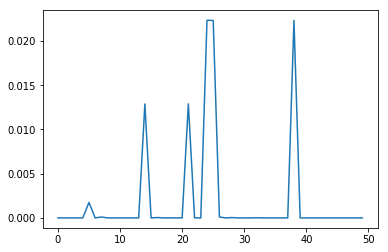

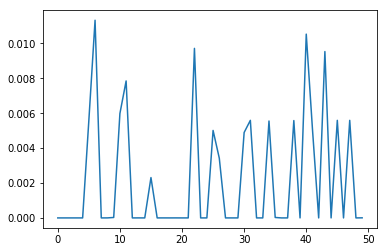

In [41]:
kf = KFold(n_splits=5, shuffle=True)
count = 0 
mu_index = 0
n_range = 100
step = 5
MSE_test = np.zeros(50)
MSE_train = np.zeros(50)
MSE_avg_test = np.zeros(50)
MSE_avg_train = np.zeros(50)
mu_v_array = np.zeros(100)

while (count < 50):
    rand_mu = random.randint(1, 100)
    rand_v = random.randint(1, 100)
    print(count)
    #print("mu=", rand_mu)
    #print("v=", rand_v/p)
    index=0

    
    for train_index, test_index in kf.split(X_data):
        
        #print("TRAIN:", train_index, "\nTEST:", test_index)
        
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        p = len(X_train[0,:])
        n = len(X_train[:,0])
        perm_size = int(len(X_train[:,0])/2)
        
        llr = LLR()
        regression = llr.fit(X_train, y_train, rand_mu, rand_v/p, mode='test', perm_size=50)
        
        Y_train = regression.Y
        
        Y_test = regression.predict(X_test)
        
        MSE_test[index] = mean_squared_error(y_test, Y_test);
        MSE_train[index] = mean_squared_error(y_train, Y_train);
        index+=1
    #print(MSE_test)
    #print(MSE_train)
    mu_v_array[mu_index] = rand_mu
    mu_v_array[mu_index+1] = rand_v
    mu_index +=2
    MSE_avg_test[count] = np.average(MSE_test)
    MSE_avg_train[count] = np.average(MSE_train)
    count+=1  

    #fig = plt.figure()
    #plt.plot(range(0, 5),MSE)
    #plt.show()
            
            
print(MSE_avg_test)
print(MSE_avg_train)

fig = plt.figure()
plt.plot(range(0, 50),MSE_avg_test)
plt.show()

plt.plot(range(0, 50),MSE_avg_train)
plt.show()
    

In [46]:
print(mu_v_array)
min_index = np.argmin(MSE_avg_test)
print("mu=", mu_v_array[2*min_index])
print("v=", mu_v_array[2*min_index+1])

[38. 16. 12. 49. 70. 95. 76. 61. 87. 19. 98. 47. 76. 67. 64. 54. 93. 34.
 95. 80. 99. 14. 40. 43. 52. 65. 89.  1. 74. 97.  8. 37. 17. 40.  7. 43.
 44. 97. 24.  4. 51. 87. 66. 77. 92. 36. 52. 85. 38.  4. 33.  8.  1. 89.
 32.  7. 52. 91. 58. 91. 91. 49. 70. 32. 77. 43. 13. 51. 37. 25. 14. 24.
 67. 83. 46.  1. 37. 38. 89. 72. 17. 78. 60. 85. 63. 18. 45.  5. 42. 58.
 88. 19. 68. 59. 70. 85. 24. 59. 98. 59.]
mu= 70.0
v= 85.0


MSE fit= 3.031096652291677e-20
MSE predict=  0.3243503078703411


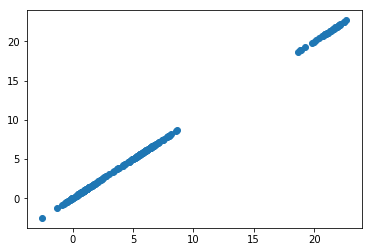

In [8]:
p = len(X[0,:])
n = len(X[:,0])
x = np.arange(0,240,1)
Theta = np.zeros(3*n)

llr = LLR()
regression = llr.fit(X_data[1:240], y_data[1:240], mu, v, mode='test', perm_size=239)
Theta = regression.Theta
Y = regression.Y
Y_test = regression.predict(X[240:300])

Theta_real = np.zeros(3*n)
for i in range(0, n):
    Theta_real[i] = 1
    
for i in range(n, int(n/3)):
    Theta_real[i] = 0
for i in range(int(n+n/3), int(2*n)):
    Theta_real[i] = 1

for i in range(2*n, int(2*n+n/3)):
    Theta_real[i] = 1
for i in range(int(2*n+n/3), int(2*n+2*n/3)):
    Theta_real[i] = 0
for i in range(int(2*n+2*n/3), 3*n):
    Theta_real[i] = 1


MSE = mean_squared_error(y_data[1:240], Y);
MSE_test = mean_squared_error(y_data[240:300], Y_test);
print("MSE fit=", MSE)
print("MSE predict= ", MSE_test)
plt.figure()
plt.scatter(y_data[1:240], Y)

plt.show() 



In [34]:

n_samples = 300
x_6dim, y_6dim = make_blobs(n_samples=n_samples, n_features=6, centers = 3, cluster_std=1.0)


Theta = np.zeros(3*n)

llr = LLR()
regression = llr.fit(x_6dim, y_6dim, mu, v, mode='test', perm_size=200)
Theta = regression.Theta
Y = regression.Y
Y_test = regression.predict(x_6dim)

MSE = mean_squared_error(y_6dim, Y);
MSE_test = mean_squared_error(y_6dim, Y_test);
print("MSE fit=", MSE)
print("MSE predict= ", MSE_test)

(4200, 4200)
(200, 4200)
MSE fit= 0.32456948010967407
MSE predict=  0.19452975625299238
